## Dogs v Cats super-charged!

In [25]:
torch.cuda.set_device(0)

In [26]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
torch.cuda.set_device(1)
PATH = "data/dogscats/"
sz=299
arch=resnext50
bs=28

In [28]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [29]:
learn.fit(1e-2, 1)
learn.precompute=False

epoch      trn_loss   val_loss   accuracy                      
    0      0.038916   0.021668   0.993     


In [ ]:
learn.fit(1e-2, 2, cycle_len=1)

  4%|▍         | 36/822 [00:05<02:00,  6.50it/s, loss=0.0387] 

In [5]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.033095   0.021473   0.9925    
    1      0.058575   0.024118   0.9915                       



[array([0.02412]), 0.9915000023841858]

In [21]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [22]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.044929   0.015602   0.9925    
    1      0.030128   0.012704   0.995                        
    2      0.031504   0.012978   0.996                        


[array([0.01298]), 0.9960000010728836]

In [23]:
learn.save('224_all_50')

In [24]:
learn.load('224_all_50')

In [25]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.997

## Analyzing results

In [26]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[996   4]
 [  2 998]]


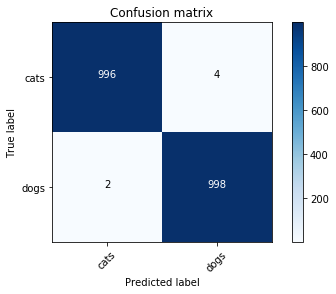

In [27]:
plot_confusion_matrix(cm, data.classes)

In [28]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):ARY_PATH includes your lib64 directory in whichever path you installed your cuda package in. You
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


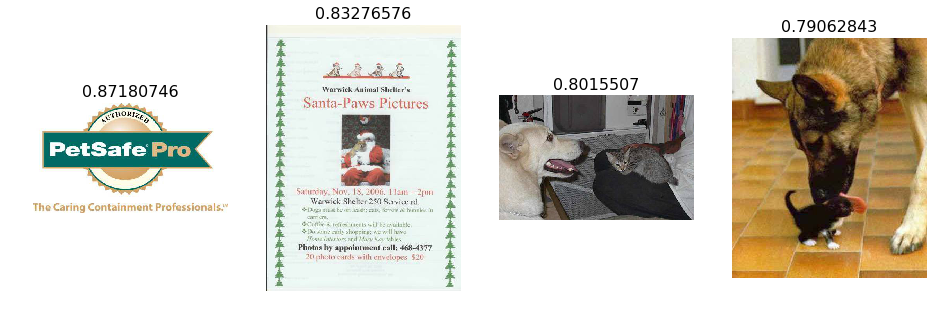

In [29]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


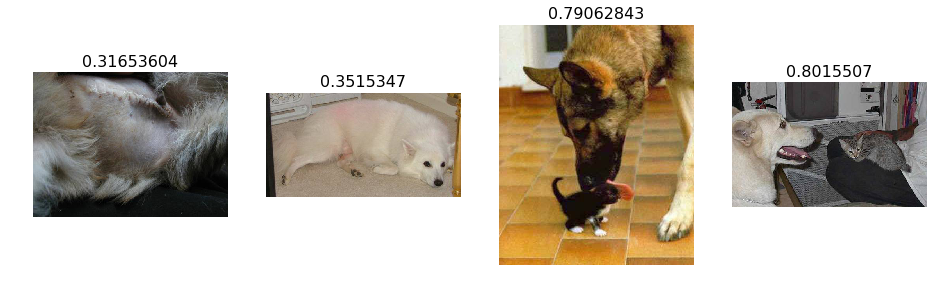

In [30]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")